In [1]:
!pip install -q nibabel imageio scikit-image tensorflow kagglehub

import os
import re
import shutil
import numpy as np
import nibabel as nib
import imageio
from skimage.transform import resize
from skimage.measure import label
from scipy.ndimage import binary_fill_holes
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import AdamW
import matplotlib.pyplot as plt
import kagglehub
from google.colab import files
from random import randint
import pandas as pd

In [2]:
n_patients = 60
modalities = ["Flair", "T1", "T2"]

# Dataset da Kaggle
dataset_path = kagglehub.dataset_download("orvile/multiple-sclerosis-brain-mri-lesion-segmentation")

base_path = dataset_path  # Path .nii
output_path = '/content/slices'  # Path slice 2D in png
os.makedirs(output_path, exist_ok=True)


100%|██████████| 761M/761M [00:03<00:00, 242MB/s]

Extracting files...


In [3]:
for modality in modalities:
  total_slices = 0

  # Preprocessing e salvataggio PNG
  for i in range(1, n_patients+1):
    try:
      img_path  = os.path.join(base_path, f'Patient-{i}', f'{i}-{modality}.nii')
      mask_path = os.path.join(base_path, f'Patient-{i}', f'{i}-LesionSeg-{modality}.nii')

      img_data = nib.load(img_path).get_fdata()
      mask_data = nib.load(mask_path).get_fdata()

      # Normalizzazione e binarizzazione
      img_data  = ((img_data - np.min(img_data)) * 255 / (np.max(img_data) - np.min(img_data))).astype(np.uint8)
      mask_data = ((mask_data > 0) * 255).astype(np.uint8)

      patient_folder = os.path.join(output_path, modality, f'Patient-{i}')
      os.makedirs(os.path.join(patient_folder, modality), exist_ok=True)
      os.makedirs(os.path.join(patient_folder, f'mask_{modality}'), exist_ok=True)

      for z in range(img_data.shape[2]):
        slice_img = img_data[:, :, z]
        slice_mask = mask_data[:, :, z]

        slice_img_resized = resize(slice_img, (256, 256), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
        slice_mask_resized = resize(slice_mask, (256, 256), order=0, preserve_range=True, anti_aliasing=False).astype(np.uint8)

        imageio.imwrite(os.path.join(patient_folder, modality, f'slice_{z:03d}.png'), slice_img_resized)
        imageio.imwrite(os.path.join(patient_folder, f'mask_{modality}', f'slice_{z:03d}.png'), slice_mask_resized)
        total_slices += 1

    except Exception as e:
      print(f"Patient-{i}: Error - {e}")
      continue
  print(f"Completed {modality}: slice totali {total_slices}")


Completed Flair: slice totali 1451
Completed T1: slice totali 1358
Completed T2: slice totali 1380


In [4]:
# Utility per dataset
def sort_slices(files):
  return sorted(files, key=lambda f: int(re.search(r'\d+', os.path.basename(f)).group()))

def get_patients_dict(slice_path, modality):
  patients = {}
  for i in range(1, n_patients+1):
      patient_folder = f"Patient-{i}"
      img_folder = os.path.join(slice_path, patient_folder, modality)
      mask_folder = os.path.join(slice_path, patient_folder, f'mask_{modality}')

      if os.path.exists(img_folder) and os.path.exists(mask_folder):
          img_files = sort_slices([os.path.join(img_folder, f) for f in os.listdir(img_folder) if f.lower().endswith('.png')])
          mask_files = sort_slices([os.path.join(mask_folder, f) for f in os.listdir(mask_folder) if f.lower().endswith('.png')])

          if len(img_files) == len(mask_files):
              patients[i] = {"image": img_files, "mask": mask_files}
  return patients

def get_train_val_test_data(patients, test_size=0.2, val_size=0.2, random_state=42):
  patient_ids = list(patients.keys())
  train_patients, test_patients = train_test_split(patient_ids, test_size=test_size, random_state=random_state)
  train_patients, val_patients = train_test_split(train_patients, test_size=val_size/(1-test_size), random_state=random_state)

  def get_data(patient_list):
      images, mask = [], []
      for p_id in patient_list:
          images.extend(patients[p_id]["image"])
          mask.extend(patients[p_id]["mask"])
      return np.array(images), np.array(mask)

  train_set = get_data(train_patients)
  val_set   = get_data(val_patients)
  test_set  = get_data(test_patients)

  total_slices = len(train_set[0]) + len(val_set[0]) + len(test_set[0])

  pct_train = (len(train_set[0]) / total_slices) * 100
  pct_val   = (len(val_set[0]) / total_slices) * 100
  pct_test  = (len(test_set[0]) / total_slices) * 100

  # Calcolo della distribuzione degli slice per set
  print("\nSlices per set:")
  print(f"  Train: {len(train_set[0])}  ({pct_train:.2f}%)")
  print(f"  Val:   {len(val_set[0])}    ({pct_val:.2f}%)")
  print(f"  Test:  {len(test_set[0])}   ({pct_test:.2f}%)")
  print(f"  Totale slices: {total_slices}")

  return train_set, val_set, test_set


# Creazione Dataset

def create_dataset(img_paths, mask_paths, batch_size=16):
  images = []
  masks = []

  for i in range(len(img_paths)):
    img = tf.io.read_file(img_paths[i])
    img = tf.image.decode_png(img, channels=1)
    img = tf.cast(img, tf.float32) / 255.0
    images.append(img.numpy())

    mask = tf.io.read_file(mask_paths[i])
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.cast(mask, tf.float32) / 255.0
    masks.append(mask.numpy())

  dataset = tf.data.Dataset.from_tensor_slices((images, masks))
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(tf.data.AUTOTUNE)

  return dataset

def augment_image(img, mask):
    # Variazioni di intensità
    if tf.random.uniform([]) > 0.5:
        brightness_factor = tf.random.uniform([], 0.9, 1.1)
        img = img * brightness_factor
        img = tf.clip_by_value(img, 0.0, 1.0)

    # Gaussian noise lieve
    if tf.random.uniform([]) > 0.5:
        noise = tf.random.normal(tf.shape(img), stddev=0.01)
        img = img + noise
        img = tf.clip_by_value(img, 0.0, 1.0)

    return img, mask

def create_dataset_train_val(img_paths, mask_paths, batch_size=16, is_training=False):
    images = []
    masks = []

    for i in range(len(img_paths)):
        img = tf.io.read_file(img_paths[i])
        img = tf.image.decode_png(img, channels=1)
        img = tf.cast(img, tf.float32) / 255.0
        images.append(img.numpy())

        mask = tf.io.read_file(mask_paths[i])
        mask = tf.image.decode_png(mask, channels=1)
        mask = tf.cast(mask, tf.float32) / 255.0
        masks.append(mask.numpy())

    dataset = tf.data.Dataset.from_tensor_slices((images, masks))

    # Shuffle solo per training
    if is_training == True:
        dataset = dataset.shuffle(buffer_size=len(images))

    # Augmentation solo per training
    if is_training == True:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    dataset = dataset.repeat()

    return dataset


# U-Net
def unet_model(input_size=(256, 256, 1)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    c5 = layers.Dropout(0.5)(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

/tmp/ipython-input-1994543517.py:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)
/tmp/ipython-input-1994543517.py:21: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_path)


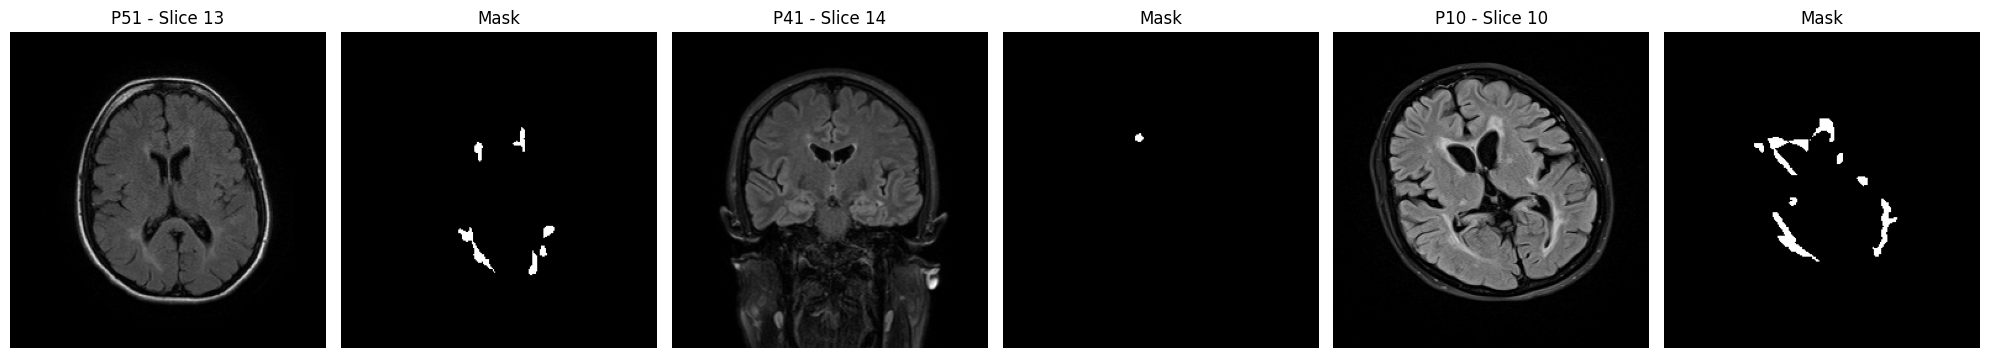

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
num_images = 3

# 1 riga con 6 colonne
fig, axes = plt.subplots(1, num_images * 2, figsize=(20, 5))

for i in range(num_images):
    patient_id = randint(1, n_patients)
    modality = modalities[0]

    patient_folder = os.path.join(output_path, modality, f'Patient-{patient_id}')
    img_folder = os.path.join(patient_folder, modality)

    if os.path.exists(img_folder):
      slice_files = sorted([f for f in os.listdir(img_folder) if f.endswith('.png')])
    slice_num = len(slice_files) // 2

    img_path = os.path.join(img_folder, f'slice_{slice_num:03d}.png')
    mask_path = os.path.join(patient_folder, f'mask_{modality}', f'slice_{slice_num:03d}.png')

    img = imageio.imread(img_path)
    mask = imageio.imread(mask_path)

    axes[i * 2].imshow(img, cmap='gray')
    axes[i * 2].set_title(f'P{patient_id} - Slice {slice_num}')
    axes[i * 2].axis('off')

    axes[i * 2 + 1].imshow(mask, cmap='gray')
    axes[i * 2 + 1].set_title('Mask')
    axes[i * 2 + 1].axis('off')

plt.tight_layout()
save_path = f'/content/dataset_samples_{modality}.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()
files.download(save_path)


In [6]:
#Loss Functions

current_dice_weight = 0.20
current_focal_weight = 0.80
current_bce_weight = 0.20
current_alpha = 0.90
current_gamma = 2.5

def bce_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred)

def dice_loss(y_true, y_pred, smooth=1e-6):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)

  # Shape
  if len(y_true.shape) == 3:
      y_true = tf.expand_dims(y_true, axis=-1)
  if len(y_pred.shape) == 3:
      y_pred = tf.expand_dims(y_pred, axis=-1)

  y_true_f = tf.reshape(y_true, [tf.shape(y_true)[0], -1])
  y_pred_f = tf.reshape(y_pred, [tf.shape(y_pred)[0], -1])

  intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=1)

  return 1 - tf.reduce_mean((2. * intersection + smooth) /
                            (tf.reduce_sum(y_true_f, axis=1) + tf.reduce_sum(y_pred_f, axis=1) + smooth))

def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0, smooth=1e-7):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)

  # Shape
  if len(y_true.shape) == 3:
      y_true = tf.expand_dims(y_true, axis=-1)
  if len(y_pred.shape) == 3:
      y_pred = tf.expand_dims(y_pred, axis=-1)

  # Clip per stabilità numerica
  y_pred = tf.clip_by_value(y_pred, smooth, 1 - smooth)

  # Binary cross entropy
  bce = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)

  # Focal term: riduce il peso degli esempi facili
  p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
  focal_term = tf.pow(1 - p_t, gamma)

  # Alpha balancing
  alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)

  focal = alpha_t * focal_term * bce

  return tf.reduce_mean(focal)

def curriculum_loss(y_true, y_pred):
    dl = dice_loss(y_true, y_pred)
    fl = focal_loss(y_true, y_pred, alpha=current_alpha, gamma=current_gamma)
    bce = bce_loss(y_true, y_pred)

    return (current_dice_weight * dl +
            current_focal_weight * fl +
            current_bce_weight  * bce)


def combined_focal_dice_loss_balanced(y_true, y_pred, alpha=0.75, gamma=2.0, dice_weight=0.35, focal_weight=0.65):
  dl = dice_loss(y_true, y_pred)
  fl = focal_loss(y_true, y_pred, alpha=alpha, gamma=gamma)

  return dice_weight * dl + focal_weight * fl




In [7]:
# Curriculum Learning Callback

class CurriculumLossCallback(Callback):

    def __init__(self, phase1_epochs=50, phase2_epochs=100):
        super().__init__()
        self.phase1_epochs = phase1_epochs
        self.phase2_epochs = phase2_epochs

    def on_epoch_begin(self, epoch, logs=None):
        global current_dice_weight, current_focal_weight, current_bce_weight
        global current_alpha, current_gamma

        if epoch < self.phase1_epochs:
            # Fase 1: Epoche 0-49 (Focal dominante)
            progress = (epoch / self.phase1_epochs) ** 4

            dice_w = 0.20 + 0.30 * progress    # 0.20 → 0.50
            focal_w = 0.80 - 0.30 * progress   # 0.80 → 0.50
            bce_w = 0.20 + 0.20 * progress

        else:
            progress = (epoch - self.phase1_epochs) / (self.phase2_epochs - self.phase1_epochs)
            dice_w = 0.50 + 0.20 * progress    # 0.50 → 0.70
            focal_w = 0.50 - 0.20 * progress   # 0.50 → 0.30
            bce_w = 0.40 + 0.10 * progress     # 0.40 → 0.50


        current_dice_weight = dice_w
        current_focal_weight = focal_w
        current_bce_weight = bce_w
        current_alpha = 0.90
        current_gamma = 2.5

        print(f"\n Curriculum - Epoca {epoch}: Dice={dice_w:.3f}, Focal={focal_w:.3f}")



In [8]:
# Metriche

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


TRAINING Flair

Slices per set:
  Train: 872  (60.10%)
  Val:   275    (18.95%)
  Test:  304   (20.95%)
  Totale slices: 1451
Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 265ms/step - accuracy: 0.8715 - dice_coef: 0.0044 - iou_coef: 0.0022 - loss: 0.3751 - precision: 0.0038 - recall: 0.2052 - val_accuracy: 0.9961 - val_dice_coef: 0.0013 - val_iou_coef: 6.7252e-04 - val_loss: 0.3598 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - accuracy: 0.9977 - dice_coef: 0.0048 - iou_coef: 0.0025 - loss: 0.3535 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9961 - val_dice_coef: 0.0520 - val_iou_coef: 0.0272 - val_loss: 0.3386 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - accuracy: 0.9976 - dice_coef: 0.0477 - iou_coef: 0.0245 - loss: 0.3422 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.996


Risultati Test - Flair:
Test Loss: 0.2801
Test Dice: 0.3288
Test IoU: 0.2191
Test Precision: 0.5993
Test Recall: 0.5158
Test Accuracy: 0.9975


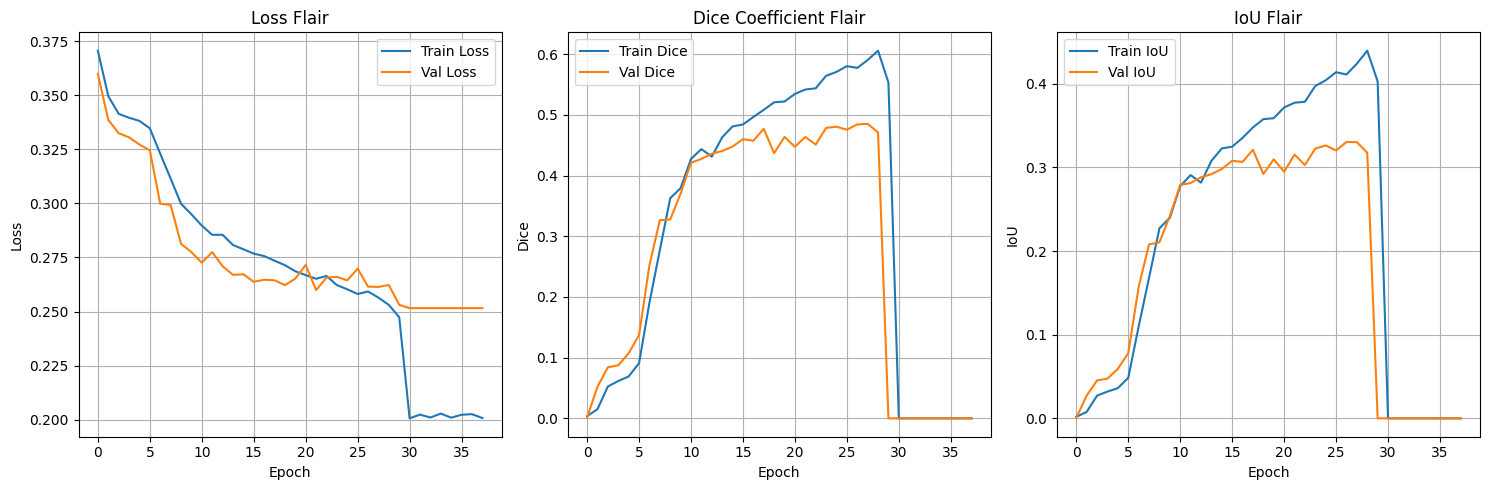

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

TRAINING T1

Slices per set:
  Train: 814  (59.94%)
  Val:   273    (20.10%)
  Test:  271   (19.96%)
  Totale slices: 1358
Epoch 1/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 62s 307ms/step - accuracy: 0.9891 - dice_coef: 0.0012 - iou_coef: 6.0552e-04 - loss: 0.3758 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9994 - val_dice_coef: 6.2488e-08 - val_iou_coef: 3.1256e-08 - val_loss: 0.3542 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 2/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.9994 - dice_coef: 9.8133e-05 - iou_coef: 4.9078e-05 - loss: 0.3530 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9994 - val_dice_coef: 8.2911e-04 - val_iou_coef: 4.1489e-04 - val_loss: 0.3508 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 3/50
152/152 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.9994 - dice_coef: 0.0037 - iou_coef: 0.0019 - loss: 0.3499 - precision: 0.0000e+00 - recall: 0.0


Risultati Test - T1:
Test Loss: 0.3479
Test Dice: 0.0215
Test IoU: 0.0112
Test Precision: 0.0268
Test Recall: 0.1074
Test Accuracy: 0.9981


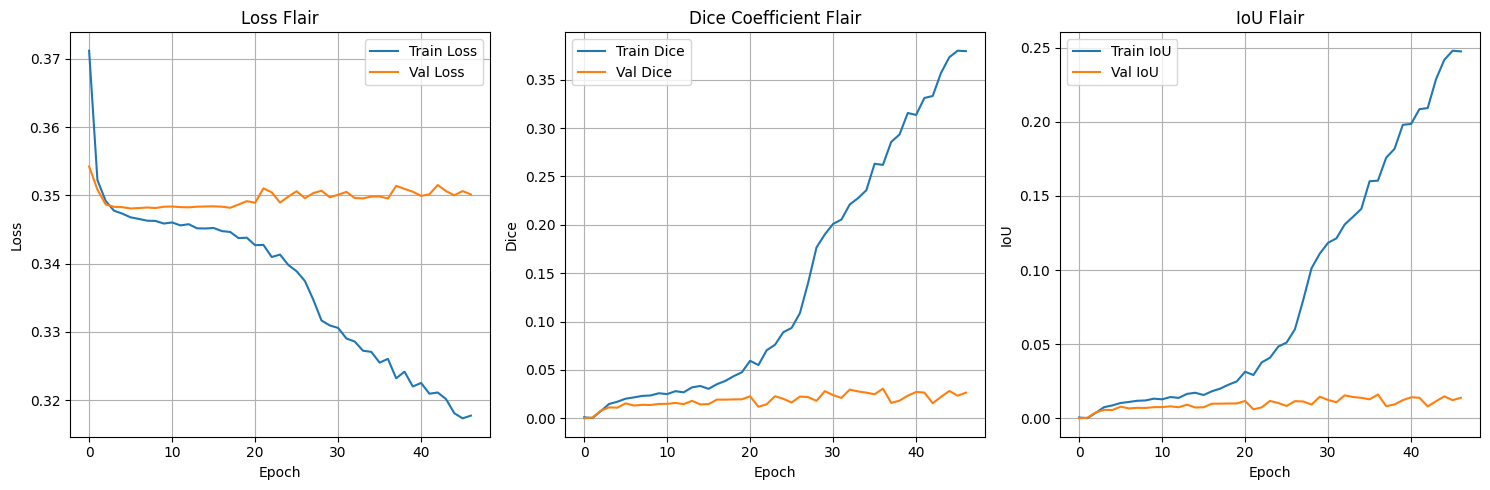

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

TRAINING T2

Slices per set:
  Train: 827  (59.93%)
  Val:   273    (19.78%)
  Test:  280   (20.29%)
  Totale slices: 1380
Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 58s 275ms/step - accuracy: 0.8856 - dice_coef: 0.0035 - iou_coef: 0.0017 - loss: 0.3761 - precision: 0.0041 - recall: 0.2418 - val_accuracy: 0.9977 - val_dice_coef: 5.2977e-04 - val_iou_coef: 2.6509e-04 - val_loss: 0.3594 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.9982 - dice_coef: 0.0014 - iou_coef: 6.8670e-04 - loss: 0.3554 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9977 - val_dice_coef: 0.0306 - val_iou_coef: 0.0159 - val_loss: 0.3443 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.9984 - dice_coef: 0.0251 - iou_coef: 0.0128 - loss: 0.3459 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 


Risultati Test - T2:
Test Loss: 0.3221
Test Dice: 0.2014
Test IoU: 0.1241
Test Precision: 0.5012
Test Recall: 0.3073
Test Accuracy: 0.9979


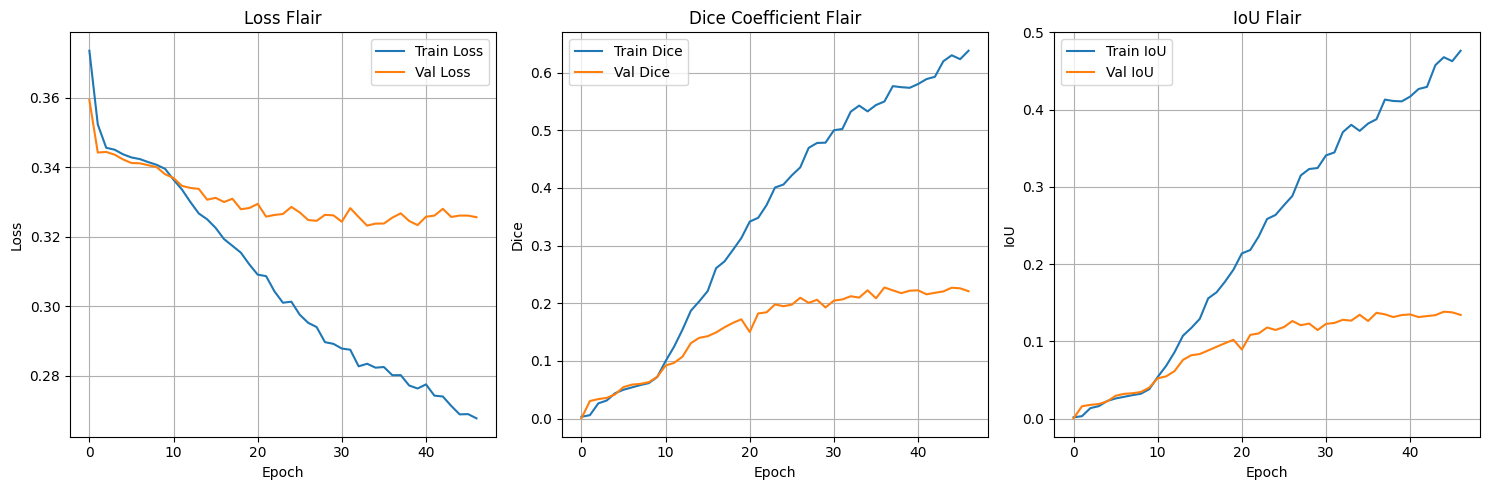

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
### FLAIR, T1 e T2 - con loss statica ###

for modality in modalities:
  print(f"TRAINING {modality}")
  slice_path = f'/content/slices/{modality}'

  # Preparazione dataset
  patients_dict = get_patients_dict(slice_path, modality=modality)
  train_data, val_data, test_data = get_train_val_test_data(patients_dict)

  num_train_images = len(train_data[0])
  num_val_images = len(val_data[0])

  batch_size = 16
  oversample_factor = 3

  steps_per_epoch = num_train_images * oversample_factor // batch_size
  validation_steps = num_val_images // batch_size

  train_dataset = create_dataset_train_val(train_data[0], train_data[1], batch_size=batch_size, is_training=True)
  val_dataset = create_dataset_train_val(val_data[0], val_data[1], batch_size=batch_size)

  # Training
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, clipnorm=1.0)

  model = unet_model()
  model.compile(
      optimizer=optimizer,
      loss=combined_focal_dice_loss_balanced,
      metrics=[dice_coef, iou_coef, tf.keras.metrics.Precision(name='precision'),
              tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.BinaryAccuracy(name='accuracy')]
  )

  early_stop = EarlyStopping(monitor='val_dice_coef', patience=10, mode='max', restore_best_weights=True)
  reduce_lr = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, patience=6, min_lr=1e-7, mode='max', verbose=1)

  history = model.fit(
      train_dataset,
      validation_data=val_dataset,
      epochs=50,
      steps_per_epoch=steps_per_epoch,
      validation_steps=validation_steps,
      callbacks=[early_stop, reduce_lr]
  )

  # Test
  test_dataset = create_dataset(test_data[0], test_data[1], batch_size=8)
  results = model.evaluate(test_dataset)

  print(f"\nRisultati Test - {modality}:")
  print(f"Test Loss: {results[0]:.4f}")
  print(f"Test Dice: {results[1]:.4f}")
  print(f"Test IoU: {results[2]:.4f}")
  print(f"Test Precision: {results[3]:.4f}")
  print(f"Test Recall: {results[4]:.4f}")
  print(f"Test Accuracy: {results[5]:.4f}")


  model.save(f'/content/model_{modality.lower()}.h5')

  ## Grafico di apprendimento
  plt.figure(figsize=(15, 5))

  plt.subplot(1, 3, 1)
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Val Loss')
  plt.title('Loss Flair')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

  plt.subplot(1, 3, 2)
  plt.plot(history.history['dice_coef'], label='Train Dice')
  plt.plot(history.history['val_dice_coef'], label='Val Dice')
  plt.title('Dice Coefficient Flair')
  plt.xlabel('Epoch')
  plt.ylabel('Dice')
  plt.legend()
  plt.grid(True)

  plt.subplot(1, 3, 3)
  plt.plot(history.history['iou_coef'], label='Train IoU')
  plt.plot(history.history['val_iou_coef'], label='Val IoU')
  plt.title('IoU Flair')
  plt.xlabel('Epoch')
  plt.ylabel('IoU')
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.savefig(f'/content/{modality.lower()}_training_history.png', dpi=300, bbox_inches='tight')
  plt.show()

  files.download(f'/content/{modality.lower()}_training_history.png')





Slices per set:
  Train: 872  (60.10%)
  Val:   275    (18.95%)
  Test:  304   (20.95%)
  Totale slices: 1451

 Curriculum - Epoca 0: Dice=0.200, Focal=0.800
Epoch 1/60
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9889 - dice_coef: 0.0096 - iou_coef: 0.0049 - loss: 0.2690 - precision: 0.0010 - recall: 0.0034
Epoch 1: val_dice_coef improved from -inf to 0.05705, saving model to /content/best_model_flair_advanced.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 164ms/step - accuracy: 0.9890 - dice_coef: 0.0097 - iou_coef: 0.0049 - loss: 0.2688 - precision: 0.0010 - recall: 0.0033 - val_accuracy: 0.9961 - val_dice_coef: 0.0571 - val_iou_coef: 0.0299 - val_loss: 0.2023 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04

 Curriculum - Epoca 1: Dice=0.200, Focal=0.800
Epoch 2/60
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9977 - dice_coef: 0.0476 - iou_coef: 0.0245 - loss: 0.2022 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2: val_dice_coef improved from 0.05705 to 0.08547, saving model to /content/best_model_flair_advanced.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - accuracy: 0.9977 - dice_coef: 0.0476 - iou_coef: 0.0245 - loss: 0.2022 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9961 - val_dice_coef: 0.0855 - val_iou_coef: 0.0460 - val_loss: 0.1992 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04

 Curriculum - Epoca 2: Dice=0.200, Focal=0.800
Epoch 3/60
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9969 - dice_coef: 0.0805 - iou_coef: 0.0426 - loss: 0.1985 - precision: 0.1301 - recall: 0.0661
Epoch 3: val_dice_coef improved from 0.08547 to 0.17543, saving model to /content/best_model_flair_advanced.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - accuracy: 0.9968 - dice_coef: 0.0806 - iou_coef: 0.0427 - loss: 0.1985 - precision: 0.1302 - recall: 0.0669 - val_accuracy: 0.9878 - val_dice_coef: 0.1754 - val_iou_coef: 0.1030 - val_loss: 0.1867 - val_precision: 0.1755 - val_recall: 0.5828 - learning_rate: 1.0000e-04

 Curriculum - Epoca 3: Dice=0.200, Focal=0.800
Epoch 4/60
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9961 - dice_coef: 0.2857 - iou_coef: 0.1723 - loss: 0.1814 - precision: 0.2812 - recall: 0.4474
Epoch 4: val_dice_coef improved from 0.17543 to 0.39752, saving model to /content/best_model_flair_advanced.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - accuracy: 0.9961 - dice_coef: 0.2860 - iou_coef: 0.1726 - loss: 0.1813 - precision: 0.2815 - recall: 0.4477 - val_accuracy: 0.9968 - val_dice_coef: 0.3975 - val_iou_coef: 0.2548 - val_loss: 0.1676 - val_precision: 0.6386 - val_recall: 0.3946 - learning_rate: 1.0000e-04

 Curriculum - Epoca 4: Dice=0.200, Focal=0.800
Epoch 5/60
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9972 - dice_coef: 0.4595 - iou_coef: 0.3054 - loss: 0.1651 - precision: 0.4441 - recall: 0.5745
Epoch 5: val_dice_coef improved from 0.39752 to 0.45420, saving model to /content/best_model_flair_advanced.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - accuracy: 0.9972 - dice_coef: 0.4596 - iou_coef: 0.3055 - loss: 0.1651 - precision: 0.4443 - recall: 0.5745 - val_accuracy: 0.9962 - val_dice_coef: 0.4542 - val_iou_coef: 0.3052 - val_loss: 0.1521 - val_precision: 0.5054 - val_recall: 0.6225 - learning_rate: 1.0000e-04

 Curriculum - Epoca 5: Dice=0.200, Focal=0.800
Epoch 6/60
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9977 - dice_coef: 0.4977 - iou_coef: 0.3403 - loss: 0.1606 - precision: 0.5071 - recall: 0.5921
Epoch 6: val_dice_coef improved from 0.45420 to 0.48792, saving model to /content/best_model_flair_advanced.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - accuracy: 0.9978 - dice_coef: 0.4978 - iou_coef: 0.3404 - loss: 0.1606 - precision: 0.5072 - recall: 0.5922 - val_accuracy: 0.9967 - val_dice_coef: 0.4879 - val_iou_coef: 0.3345 - val_loss: 0.1531 - val_precision: 0.5734 - val_recall: 0.5905 - learning_rate: 1.0000e-04

 Curriculum - Epoca 6: Dice=0.200, Focal=0.800
Epoch 7/60
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9980 - dice_coef: 0.5339 - iou_coef: 0.3714 - loss: 0.1569 - precision: 0.5333 - recall: 0.6141
Epoch 7: val_dice_coef did not improve from 0.48792
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - accuracy: 0.9980 - dice_coef: 0.5339 - iou_coef: 0.3714 - loss: 0.1569 - precision: 0.5334 - recall: 0.6141 - val_accuracy: 0.9971 - val_dice_coef: 0.4855 - val_iou_coef: 0.3261 - val_loss: 0.1563 - val_precision: 0.6971 - val_recall: 0.4444 - learning_rate: 1.0000e-04

 Curriculum - Epoca 7: Dice=0.201, Focal=0.799
Epoch 8/60
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accu

163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - accuracy: 0.9982 - dice_coef: 0.5976 - iou_coef: 0.4309 - loss: 0.1500 - precision: 0.6005 - recall: 0.6579 - val_accuracy: 0.9971 - val_dice_coef: 0.4908 - val_iou_coef: 0.3317 - val_loss: 0.1553 - val_precision: 0.6877 - val_recall: 0.4770 - learning_rate: 1.0000e-04

 Curriculum - Epoca 9: Dice=0.202, Focal=0.798
Epoch 10/60
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9984 - dice_coef: 0.6291 - iou_coef: 0.4632 - loss: 0.1445 - precision: 0.6428 - recall: 0.6822
Epoch 10: val_dice_coef improved from 0.49076 to 0.50878, saving model to /content/best_model_flair_advanced.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - accuracy: 0.9984 - dice_coef: 0.6291 - iou_coef: 0.4632 - loss: 0.1445 - precision: 0.6429 - recall: 0.6822 - val_accuracy: 0.9971 - val_dice_coef: 0.5088 - val_iou_coef: 0.3500 - val_loss: 0.1535 - val_precision: 0.6577 - val_recall: 0.5382 - learning_rate: 1.0000e-04

 Curriculum - Epoca 10: Dice=0.204, Focal=0.796
Epoch 11/60
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9985 - dice_coef: 0.6662 - iou_coef: 0.5031 - loss: 0.1404 - precision: 0.6820 - recall: 0.7174
Epoch 11: val_dice_coef did not improve from 0.50878
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - accuracy: 0.9985 - dice_coef: 0.6662 - iou_coef: 0.5031 - loss: 0.1404 - precision: 0.6820 - recall: 0.7174 - val_accuracy: 0.9970 - val_dice_coef: 0.5011 - val_iou_coef: 0.3443 - val_loss: 0.1528 - val_precision: 0.6149 - val_recall: 0.5950 - learning_rate: 1.0000e-04

 Curriculum - Epoca 11: Dice=0.205, Focal=0.795
Epoch 12/60
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step -

163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - accuracy: 0.9982 - dice_coef: 0.5472 - iou_coef: 0.3829 - loss: 0.0789 - precision: 0.5990 - recall: 0.5786 - val_accuracy: 0.9971 - val_dice_coef: 0.5154 - val_iou_coef: 0.3514 - val_loss: 0.0986 - val_precision: 0.6725 - val_recall: 0.4905 - learning_rate: 5.0000e-05

 Curriculum - Epoca 22: Dice=0.287, Focal=0.713
Epoch 23/60
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9982 - dice_coef: 0.5840 - iou_coef: 0.4175 - loss: 0.0744 - precision: 0.6368 - recall: 0.6050
Epoch 23: val_dice_coef did not improve from 0.51537
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - accuracy: 0.9982 - dice_coef: 0.5840 - iou_coef: 0.4175 - loss: 0.0744 - precision: 0.6366 - recall: 0.6050 - val_accuracy: 0.9970 - val_dice_coef: 0.5150 - val_iou_coef: 0.3534 - val_loss: 0.0977 - val_precision: 0.6316 - val_recall: 0.5388 - learning_rate: 5.0000e-05

 Curriculum - Epoca 23: Dice=0.304, Focal=0.696
Epoch 24/60
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step -

163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - accuracy: 0.9983 - dice_coef: 0.5941 - iou_coef: 0.4273 - loss: 0.0726 - precision: 0.6327 - recall: 0.6098 - val_accuracy: 0.9969 - val_dice_coef: 0.5245 - val_iou_coef: 0.3652 - val_loss: 0.0911 - val_precision: 0.5973 - val_recall: 0.6293 - learning_rate: 5.0000e-05

 Curriculum - Epoca 25: Dice=0.345, Focal=0.655
Epoch 26/60
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9984 - dice_coef: 0.6218 - iou_coef: 0.4549 - loss: 0.0654 - precision: 0.6446 - recall: 0.6622
Epoch 26: val_dice_coef improved from 0.52448 to 0.52845, saving model to /content/best_model_flair_advanced.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - accuracy: 0.9984 - dice_coef: 0.6218 - iou_coef: 0.4549 - loss: 0.0654 - precision: 0.6446 - recall: 0.6621 - val_accuracy: 0.9969 - val_dice_coef: 0.5285 - val_iou_coef: 0.3687 - val_loss: 0.0972 - val_precision: 0.5997 - val_recall: 0.6118 - learning_rate: 5.0000e-05

 Curriculum - Epoca 26: Dice=0.369, Focal=0.631
Epoch 27/60
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9984 - dice_coef: 0.6301 - iou_coef: 0.4642 - loss: 0.0676 - precision: 0.6621 - recall: 0.6661
Epoch 27: val_dice_coef did not improve from 0.52845
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - accuracy: 0.9984 - dice_coef: 0.6300 - iou_coef: 0.4641 - loss: 0.0676 - precision: 0.6620 - recall: 0.6661 - val_accuracy: 0.9972 - val_dice_coef: 0.5190 - val_iou_coef: 0.3581 - val_loss: 0.0926 - val_precision: 0.6813 - val_recall: 0.5380 - learning_rate: 5.0000e-05

 Curriculum - Epoca 27: Dice=0.397, Focal=0.603
Epoch 28/60
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step -

163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - accuracy: 0.9987 - dice_coef: 0.6981 - iou_coef: 0.5396 - loss: 0.0543 - precision: 0.7307 - recall: 0.7257 - val_accuracy: 0.9970 - val_dice_coef: 0.5316 - val_iou_coef: 0.3696 - val_loss: 0.1012 - val_precision: 0.6272 - val_recall: 0.5889 - learning_rate: 5.0000e-05

 Curriculum - Epoca 34: Dice=0.527, Focal=0.473
Epoch 35/60
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9987 - dice_coef: 0.6889 - iou_coef: 0.5298 - loss: 0.0598 - precision: 0.7115 - recall: 0.7362
Epoch 35: val_dice_coef did not improve from 0.53158
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - accuracy: 0.9987 - dice_coef: 0.6889 - iou_coef: 0.5298 - loss: 0.0598 - precision: 0.7115 - recall: 0.7361 - val_accuracy: 0.9970 - val_dice_coef: 0.4589 - val_iou_coef: 0.3071 - val_loss: 0.1087 - val_precision: 0.6648 - val_recall: 0.4549 - learning_rate: 5.0000e-05

 Curriculum - Epoca 35: Dice=0.533, Focal=0.467
Epoch 36/60
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step -

38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9982 - dice_coef: 0.4004 - iou_coef: 0.2956 - loss: 0.2988 - precision: 0.5251 - recall: 0.4867



Risultati Test - Flair:
Test Loss: 0.2595
Test Dice: 0.5025
Test IoU: 0.3819
Test Precision: 0.6414
Test Recall: 0.5303
Test Accuracy: 0.9977


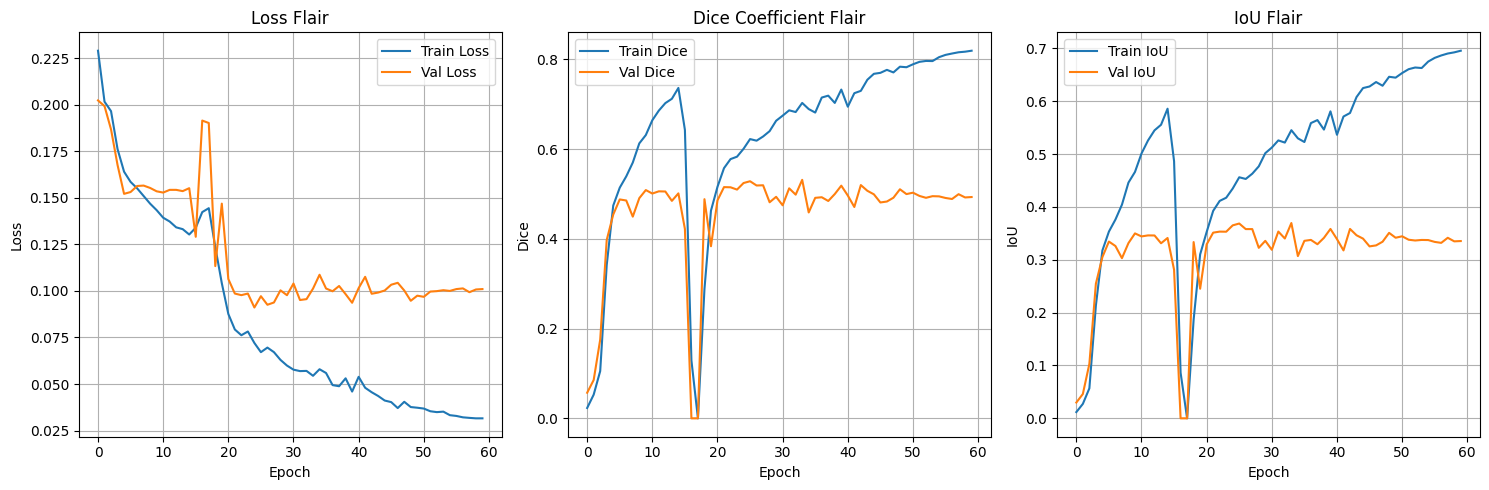

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
### FLAIR - Curriculum loss ###

modality = "Flair"
slice_path = f'/content/slices/{modality}'

# Preparazione dataset
patients_dict = get_patients_dict(slice_path, modality=modality)
train_data, val_data, test_data = get_train_val_test_data(patients_dict)


num_train_images = len(train_data[0])
num_val_images = len(val_data[0])

batch_size = 16
oversample_factor = 3

steps_per_epoch = num_train_images * oversample_factor // batch_size
validation_steps = num_val_images // batch_size

train_dataset = create_dataset_train_val(train_data[0], train_data[1], batch_size=batch_size, is_training=True)
val_dataset = create_dataset_train_val(val_data[0], val_data[1], batch_size=batch_size)

# Training e validation
early_stop = EarlyStopping(monitor='val_dice_coef', patience=30, mode='max', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, patience=10, min_lr=1e-7, mode='max', verbose=1)
curriculum_loss_callback = CurriculumLossCallback(phase1_epochs=30, phase2_epochs=60)
checkpoint = ModelCheckpoint('/content/best_model_flair_advanced.h5', monitor='val_dice_coef', mode='max', save_best_only=True, verbose=1)

optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-4, clipnorm=1.0)
model_flair = unet_model()

model_flair.compile(
    optimizer=optimizer,
    loss=curriculum_loss,
    metrics=[dice_coef, iou_coef, tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.BinaryAccuracy(name='accuracy')]
)

history_flair = model_flair.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=60,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stop, reduce_lr, checkpoint, curriculum_loss_callback]
)

best_model = tf.keras.models.load_model(
    '/content/best_model_flair_advanced.h5',
    custom_objects={
        'curriculum_loss': curriculum_loss,
        'dice_coef': dice_coef,
        'iou_coef': iou_coef
    }
)

# Test
test_dataset = create_dataset(test_data[0], test_data[1], batch_size=8)
results = best_model.evaluate(test_dataset, verbose=1)

print(f"\nRisultati Test - {modality}:")
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Dice: {results[1]:.4f}")
print(f"Test IoU: {results[2]:.4f}")
print(f"Test Precision: {results[3]:.4f}")
print(f"Test Recall: {results[4]:.4f}")
print(f"Test Accuracy: {results[5]:.4f}")


best_model.save('/content/model_flair_advanced.h5')

## Grafico di apprendimento
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history_flair.history['loss'], label='Train Loss')
plt.plot(history_flair.history['val_loss'], label='Val Loss')
plt.title('Loss Flair')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history_flair.history['dice_coef'], label='Train Dice')
plt.plot(history_flair.history['val_dice_coef'], label='Val Dice')
plt.title('Dice Coefficient Flair')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history_flair.history['iou_coef'], label='Train IoU')
plt.plot(history_flair.history['val_iou_coef'], label='Val IoU')
plt.title('IoU Flair')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('/content/flair_advanced_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

files.download('/content/flair_advanced_training_history.png')


VISUALIZZAZIONE PREDIZIONI SU TEST SET


MODALITÀ: Flair

Slices per set:
  Train: 872  (60.10%)
  Val:   275    (18.95%)
  Test:  304   (20.95%)
  Totale slices: 1451
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


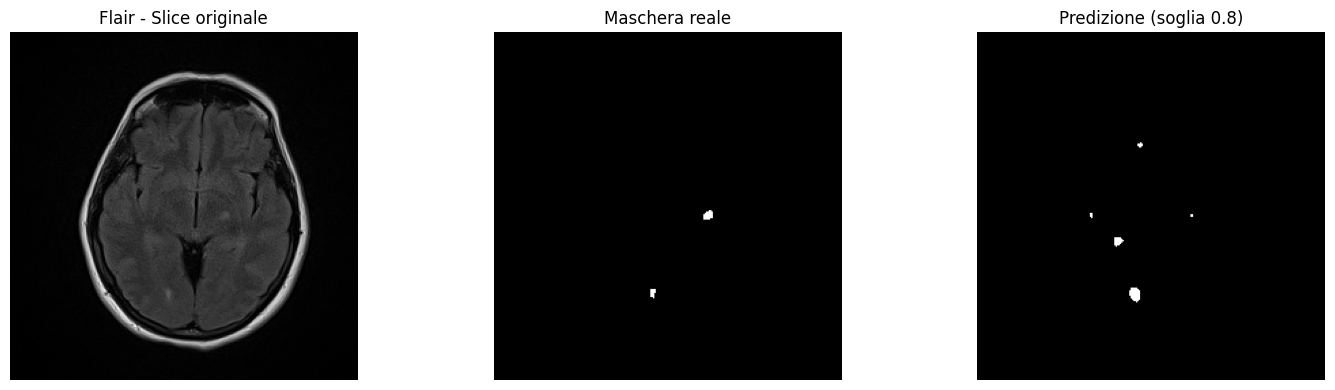

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


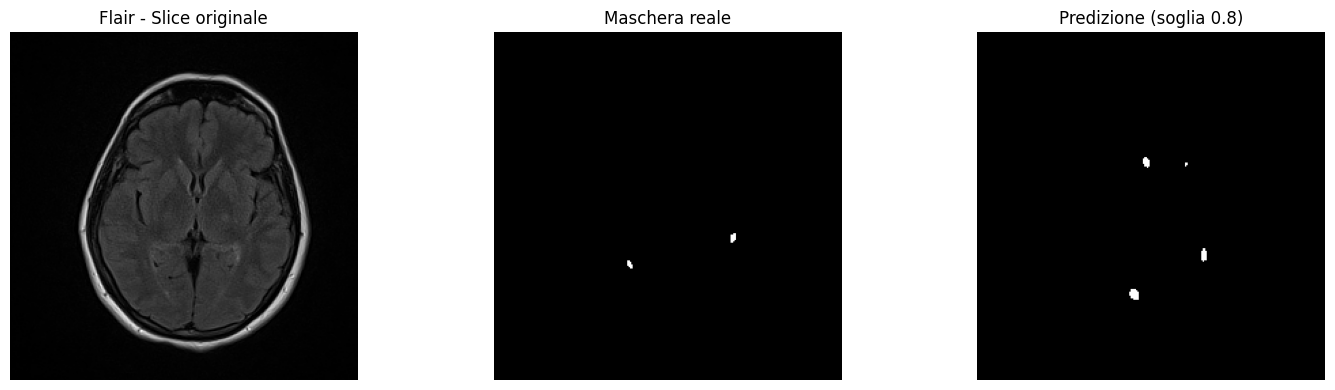

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


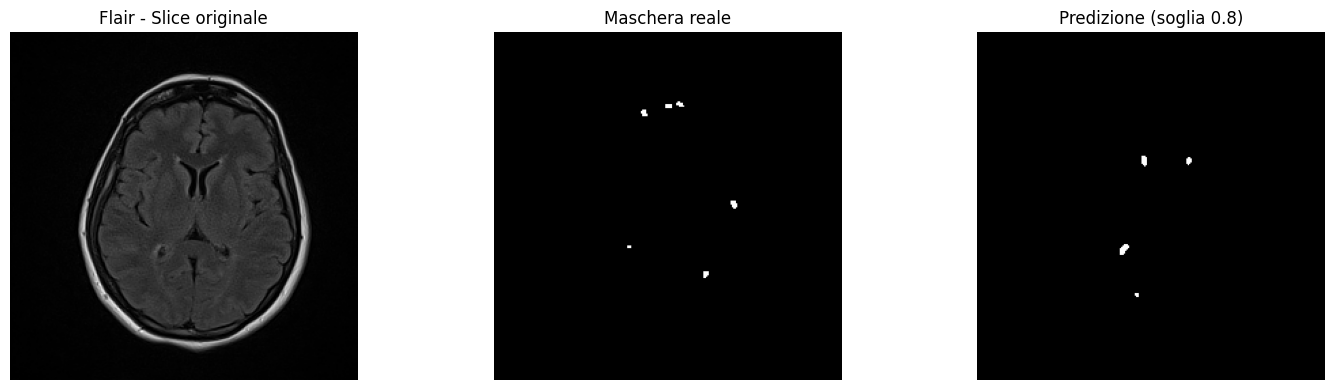

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

MODALITÀ: T1

Slices per set:
  Train: 814  (59.94%)
  Val:   273    (20.10%)
  Test:  271   (19.96%)
  Totale slices: 1358


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step


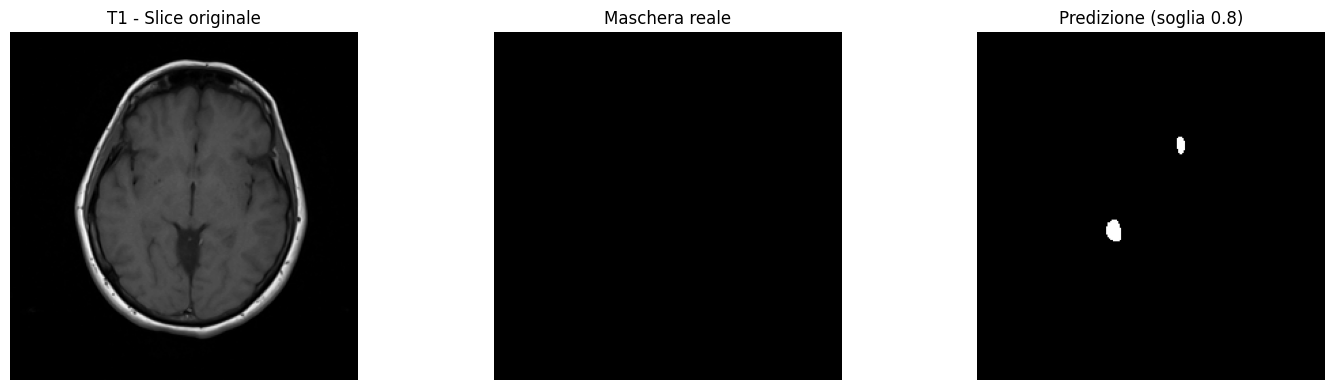

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


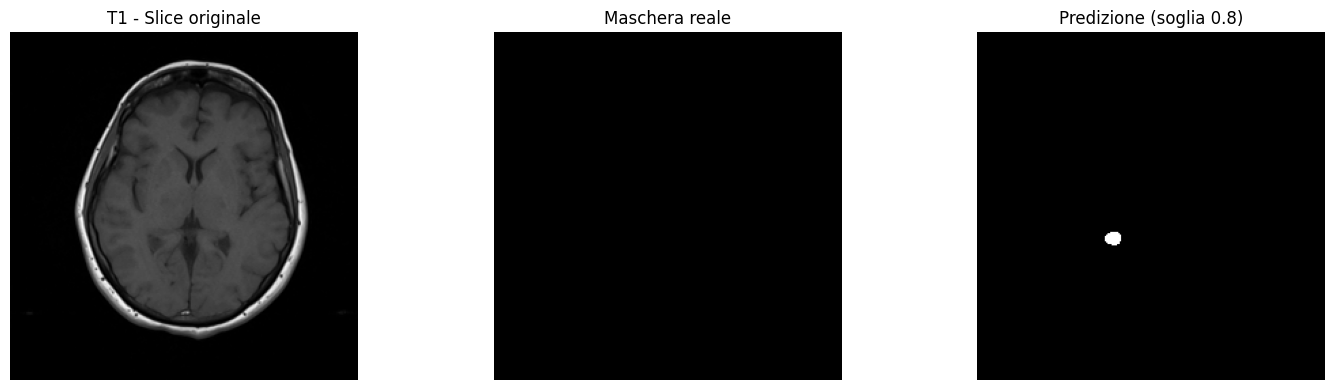

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


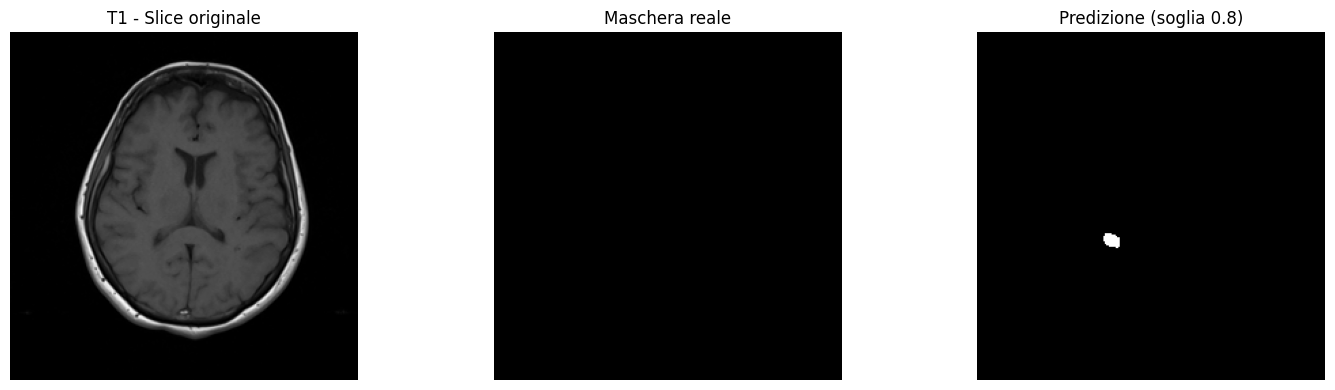

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

MODALITÀ: T2

Slices per set:
  Train: 827  (59.93%)
  Val:   273    (19.78%)
  Test:  280   (20.29%)
  Totale slices: 1380


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step


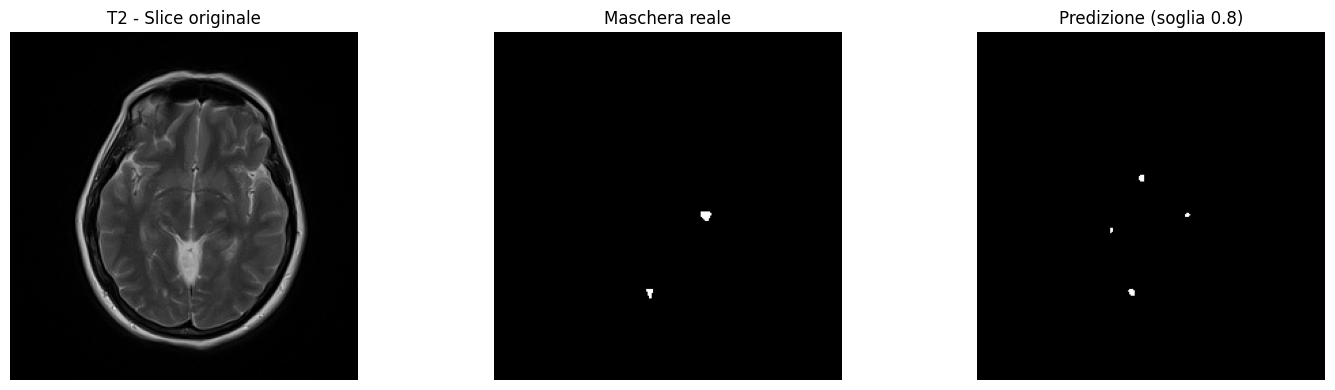

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


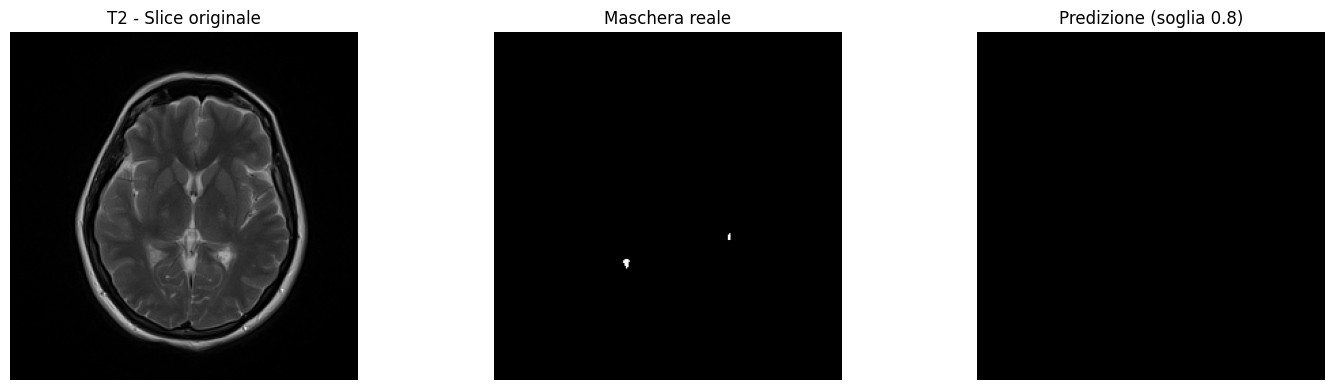

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


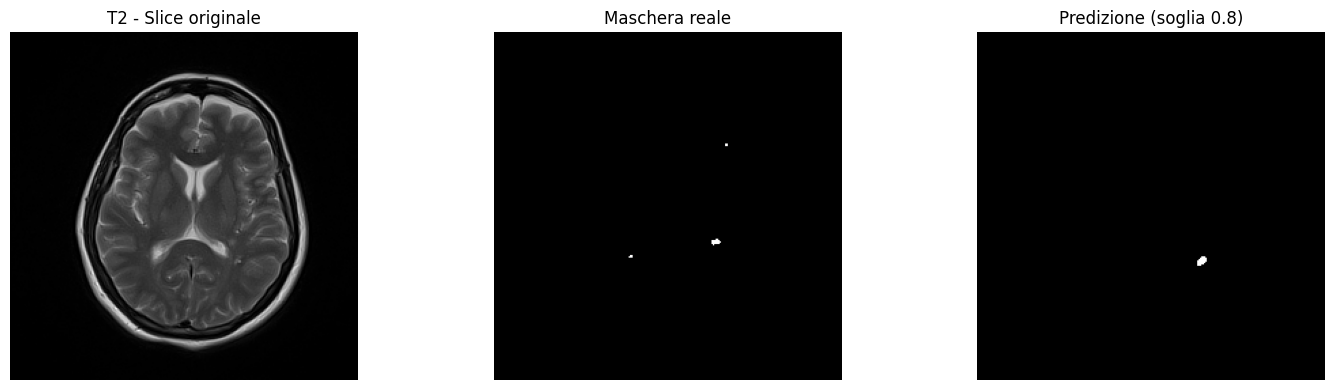

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

MODALITÀ: Flair_advanced

Slices per set:
  Train: 872  (60.10%)
  Val:   275    (18.95%)
  Test:  304   (20.95%)
  Totale slices: 1451
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step


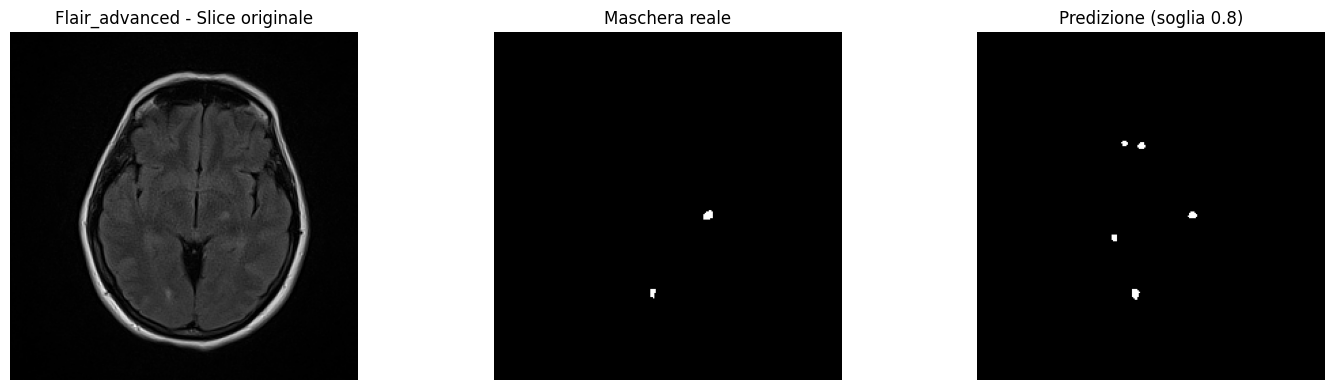

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


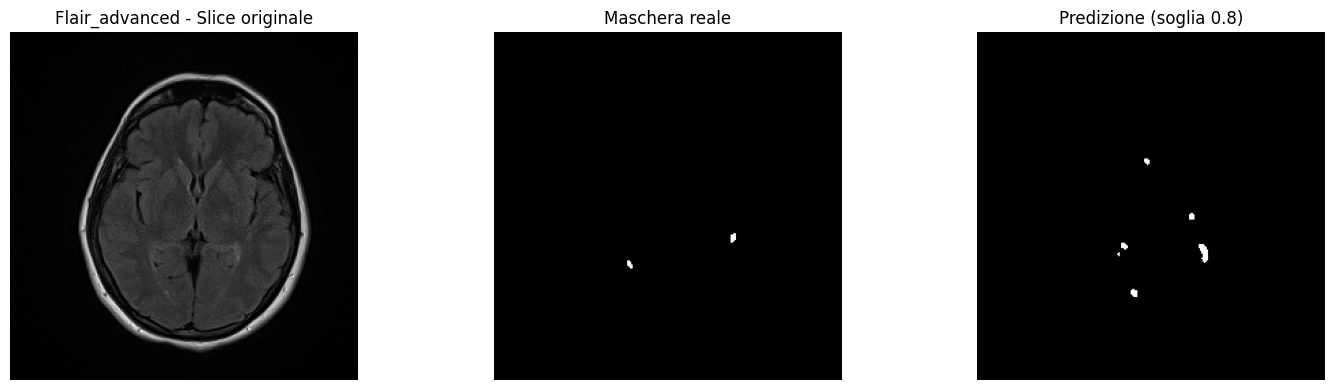

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


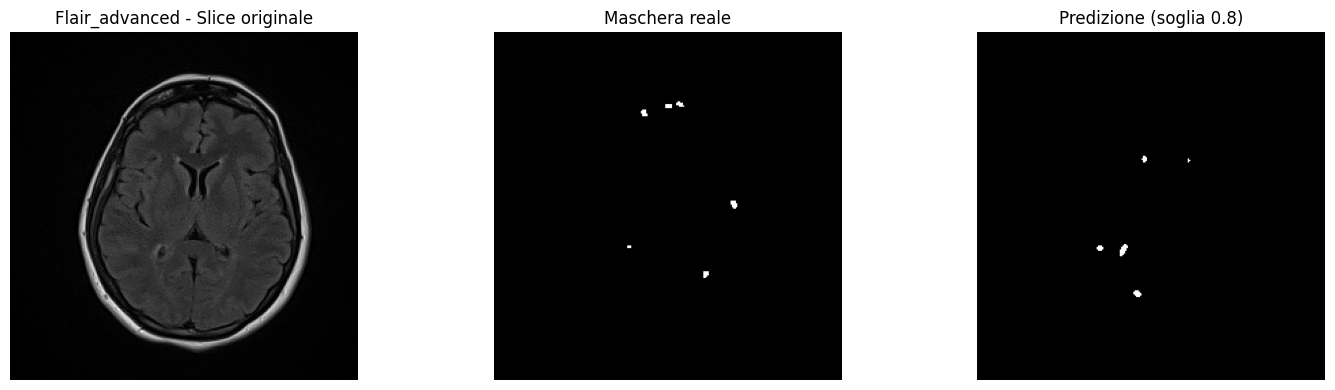

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
# Predizioni
print("VISUALIZZAZIONE PREDIZIONI SU TEST SET")

model_flair = load_model('/content/model_flair.h5', custom_objects={'combined_focal_dice_loss_balanced': combined_focal_dice_loss_balanced, 'dice_coef': dice_coef, 'iou_coef': iou_coef})
model_t1 = load_model('/content/model_t1.h5', custom_objects={'combined_focal_dice_loss_balanced': combined_focal_dice_loss_balanced, 'dice_coef': dice_coef, 'iou_coef': iou_coef})
model_t2 = load_model('/content/model_t2.h5', custom_objects={'combined_focal_dice_loss_balanced': combined_focal_dice_loss_balanced, 'dice_coef': dice_coef, 'iou_coef': iou_coef})
model_flair_advanced = load_model('/content/model_flair_advanced.h5', custom_objects={'curriculum_loss': curriculum_loss, 'dice_coef': dice_coef, 'iou_coef': iou_coef})

num_samples = 3
skip = 10
modalities_extended = ["Flair", "T1", "T2", "Flair_advanced"]


for modality in modalities_extended:
    print(f"MODALITÀ: {modality}")

    slice_modality = "Flair" if modality == "Flair_advanced" else modality

    slice_path = f'/content/slices/{slice_modality}'
    patients_dict = get_patients_dict(slice_path, modality=slice_modality)
    _, _, test_data = get_train_val_test_data(patients_dict)

    if modality == 'Flair':
        model_mod = model_flair
    elif modality == 'T1':
        model_mod = model_t1
    elif modality == 'T2':
        model_mod = model_t2
    elif modality == 'Flair_advanced':
        model_mod = model_flair_advanced

    img_paths, mask_paths = test_data


    for i in range(skip, min(skip + num_samples, len(img_paths))):
        # Immagine
        img = tf.io.read_file(img_paths[i])
        img = tf.image.decode_png(img, channels=1)
        img = tf.cast(img, tf.float32) / 255.0

        # Maschera
        mask_img = tf.io.read_file(mask_paths[i])
        mask_img = tf.image.decode_png(mask_img, channels=1)
        mask_img = tf.cast(mask_img, tf.float32) / 255.0

        # Predizione
        pred_mask = model_mod.predict(tf.expand_dims(img, axis=0))[0,:,:,0]

        # Binarizzazione
        pred_mask_binary = (pred_mask > 0.8).astype(float)

        # Visualizzazione
        plt.figure(figsize=(15,4))

        plt.subplot(1,3,1)
        plt.imshow(img[:,:,0], cmap='gray')
        plt.title(f'{modality} - Slice originale')
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.imshow(mask_img[:,:,0], cmap='gray')
        plt.title('Maschera reale')
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.imshow(pred_mask_binary, cmap='gray')
        plt.title('Predizione (soglia 0.8)')
        plt.axis('off')

        plt.tight_layout()
        plt.savefig(f'/content/prediction_{modality}_{i}.png', dpi=150, bbox_inches='tight')
        plt.show()

        files.download(f'/content/prediction_{modality}_{i}.png')


In [18]:
# Post-processing
def remove_false_lesions(volume, min_voxels=27):
    labeled = label(volume > 0, connectivity=3)

    for region_id in range(1, labeled.max() + 1):
        region_size = np.sum(labeled == region_id)
        if region_size < min_voxels:
            volume[labeled == region_id] = 0

    return volume

def fill_holes_in_volume(volume):
    return binary_fill_holes(volume).astype(volume.dtype)


In [19]:
# Ricostruzione 3D
def reconstruct_3d_volume(model, patient_id, modality, slice_path, output_dir, threshold=0.5, apply_postprocessing=True):

    patient_folder = os.path.join(slice_path, f'Patient-{patient_id}')
    img_folder = os.path.join(patient_folder, modality)

    if not os.path.exists(img_folder):
        print(f"Paziente {patient_id} non trovato!")
        return None, None

    # Ordinamento slice
    slice_imgs = [f for f in os.listdir(img_folder) if f.endswith('.png')]
    slice_imgs = sort_slices([os.path.join(img_folder, f) for f in slice_imgs])

    original_slices = []
    predicted_slices = []


    for slice_img in slice_imgs:
        img = tf.io.read_file(slice_img)
        img = tf.image.decode_png(img, channels=1)
        img = tf.cast(img, tf.float32) / 255.0

        pred = model.predict(tf.expand_dims(img, axis=0), verbose=0)[0, :, :, 0]
        pred_binary = (pred > threshold).astype(np.uint8)

        original_slices.append(img.numpy()[:, :, 0])
        predicted_slices.append(pred_binary)

    # Stack
    original_volume = np.stack(original_slices, axis=2)
    predicted_volume = np.stack(predicted_slices, axis=2)


    if apply_postprocessing:
        predicted_volume = remove_false_lesions(predicted_volume, min_voxels=27)
        predicted_volume = fill_holes_in_volume(predicted_volume)


    # Carica il file nii per recuperare affine matrix e header
    original_nii_path = f'/content/multiple-sclerosis-dataset/archive/Patient-{patient_id}/{patient_id}-{modality}.nii'

    if os.path.exists(original_nii_path):
        original_nii = nib.load(original_nii_path)
        affine = original_nii.affine
        header = original_nii.header.copy()
    else:
        affine = np.eye(4)
        header = None

    os.makedirs(output_dir, exist_ok=True)

    original_nii = nib.Nifti1Image(original_volume, affine, header)
    original_output_path = os.path.join(output_dir, f'Patient-{patient_id}_{modality}_reconstructed.nii.gz')
    nib.save(original_nii, original_output_path)

    predicted_nii = nib.Nifti1Image(predicted_volume.astype(np.uint8) * 255, affine, header)
    predicted_output_path = os.path.join(output_dir, f'Patient-{patient_id}_{modality}_predicted_mask.nii.gz')
    nib.save(predicted_nii, predicted_output_path)

    print(f"   Paziente {patient_id}:")
    print(f"   Originale: {original_output_path}")
    print(f"   Predetto:  {predicted_output_path}")
    print(f"   Shape: {predicted_volume.shape}")
    print(f"   Lesioni predette: {np.sum(predicted_volume > 0)} voxel")

    return original_volume, predicted_volume


def reconstruct_all_test_patients(model, modality, slice_path, test_patient_ids, output_dir, threshold=0.5):
  for patient_id in test_patient_ids:
      try:
          orig_vol, pred_vol = reconstruct_3d_volume(model, patient_id, modality, slice_path, output_dir, threshold)
      except Exception as e:
          print(f"Errore con Patient-{patient_id}: {e}")
          continue

def evaluate_3d_reconstruction(ground_truth_path, predicted_path):
    """Valuta le metriche 3D su volumi ricostruiti."""
    gt = nib.load(ground_truth_path).get_fdata()
    pred = nib.load(predicted_path).get_fdata()

    gt_binary = (gt > 0).astype(np.float32)
    pred_binary = (pred > 0).astype(np.float32)

    intersection = np.sum(gt_binary * pred_binary)
    union = np.sum(gt_binary) + np.sum(pred_binary) - intersection

    dice_3d = (2 * intersection + 1e-6) / (np.sum(gt_binary) + np.sum(pred_binary) + 1e-6)
    iou_3d = (intersection + 1e-6) / (union + 1e-6)

    tp = intersection
    fp = np.sum(pred_binary) - intersection
    fn = np.sum(gt_binary) - intersection

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)

    return {
        'dice_3d': dice_3d,
        'iou_3d': iou_3d,
        'precision_3d': precision,
        'recall_3d': recall,
        'lesion_volume_gt': np.sum(gt_binary),
        'lesion_volume_pred': np.sum(pred_binary)
    }


In [21]:
# Ricostruzione per tutte le modalità + Flair_advanced
output_dir = '/content/3d_reconstructions'

# Dizionario modelli-modalità
models_dict = {
    "Flair": model_flair,
    "T1": model_t1,
    "T2": model_t2,
    "Flair_advanced": model_flair_advanced
}

for modality, model in models_dict.items():
    print(f"MODALITÀ: {modality}")

    slice_modality = "Flair" if modality == "Flair_advanced" else modality

    # Pazienti del test set
    slice_path = f'/content/slices/{slice_modality}'
    patients_dict = get_patients_dict(slice_path, modality=slice_modality)
    train_data, val_data, test_data = get_train_val_test_data(patients_dict)

    test_patient_ids = sorted(set(
        int(img_path.split('Patient-')[1].split('/')[0])
        for img_path in test_data[0]
    ))

    reconstruct_all_test_patients(
        model=model,
        modality=slice_modality,
        slice_path=slice_path,
        test_patient_ids=test_patient_ids,
        output_dir=os.path.join(output_dir, modality),
        threshold=0.5
    )

shutil.make_archive('/content/3d_volumes', 'zip', output_dir)
files.download('/content/3d_volumes.zip')



MODALITÀ: Flair

Slices per set:
  Train: 872  (60.10%)
  Val:   275    (18.95%)
  Test:  304   (20.95%)
  Totale slices: 1451
   Paziente 1:
   Originale: /content/3d_reconstructions/Flair/Patient-1_Flair_reconstructed.nii.gz
   Predetto:  /content/3d_reconstructions/Flair/Patient-1_Flair_predicted_mask.nii.gz
   Shape: (256, 256, 23)
   Lesioni predette: 1070 voxel
   Paziente 6:
   Originale: /content/3d_reconstructions/Flair/Patient-6_Flair_reconstructed.nii.gz
   Predetto:  /content/3d_reconstructions/Flair/Patient-6_Flair_predicted_mask.nii.gz
   Shape: (256, 256, 26)
   Lesioni predette: 2415 voxel
   Paziente 13:
   Originale: /content/3d_reconstructions/Flair/Patient-13_Flair_reconstructed.nii.gz
   Predetto:  /content/3d_reconstructions/Flair/Patient-13_Flair_predicted_mask.nii.gz
   Shape: (256, 256, 18)
   Lesioni predette: 9232 voxel
   Paziente 14:
   Originale: /content/3d_reconstructions/Flair/Patient-14_Flair_reconstructed.nii.gz
   Predetto:  /content/3d_reconstructio

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
# Risultati test dopo pre-processing e ricostruzione 3d

print("Valutazione finale sui volumi 3d ricostruiti")

results_3d = {mod: [] for mod in modalities_extended}

for modality in modalities_extended:
    print(f"{modality}")

    recon_dir = os.path.join(output_dir, modality)
    gt_base = base_path


    slice_modality = "Flair" if modality == "Flair_advanced" else modality

    slice_path = f'/content/slices/{slice_modality}'
    patients_dict = get_patients_dict(slice_path, modality=slice_modality)
    _, _, test_data = get_train_val_test_data(patients_dict)

    test_patient_ids = sorted(set(
        int(p.split('Patient-')[1].split('/')[0]) for p in test_data[0]
    ))

    for pid in test_patient_ids:
        pred_path = os.path.join(recon_dir, f'Patient-{pid}_{slice_modality}_predicted_mask.nii.gz')
        gt_path = os.path.join(base_path, f'Patient-{pid}', f'{pid}-LesionSeg-{slice_modality}.nii')

        if os.path.exists(pred_path) and os.path.exists(gt_path):
            try:
                 # Carica volumi
                gt_nii = nib.load(gt_path)
                pred_nii = nib.load(pred_path)

                gt = gt_nii.get_fdata()
                pred = pred_nii.get_fdata()

                # CORREZIONE: Resize predizione alle dimensioni originali
                if gt.shape != pred.shape:
                    print(f"  Patient-{pid}: Resize da {pred.shape} a {gt.shape}")
                    pred = resize(pred, gt.shape, order=0, preserve_range=True, anti_aliasing=False)

                # Binarizza
                gt_binary = (gt > 0).astype(np.float32)
                pred_binary = (pred > 0).astype(np.float32)

                # Calcola metriche
                intersection = np.sum(gt_binary * pred_binary)
                union = np.sum(gt_binary) + np.sum(pred_binary) - intersection

                dice_3d = (2 * intersection + 1e-6) / (np.sum(gt_binary) + np.sum(pred_binary) + 1e-6)
                iou_3d = (intersection + 1e-6) / (union + 1e-6)

                tp = intersection
                fp = np.sum(pred_binary) - intersection
                fn = np.sum(gt_binary) - intersection

                precision = tp / (tp + fp + 1e-6)
                recall = tp / (tp + fn + 1e-6)

                metrics = {
                    'dice_3d': dice_3d,
                    'iou_3d': iou_3d,
                    'precision_3d': precision,
                    'recall_3d': recall,
                    'lesion_volume_gt': np.sum(gt_binary),
                    'lesion_volume_pred': np.sum(pred_binary)
                }

                results_3d[modality].append(metrics)
                print(f"Patient-{pid}: Dice3D={dice_3d:.4f}, IoU3D={iou_3d:.4f}")

            except Exception as e:
                print(f"Patient-{pid}: Errore - {e}")
        else:
            if not os.path.exists(pred_path):
                print(f"Patient-{pid}: Pred non trovato")
            if not os.path.exists(gt_path):
                print(f"Patient-{pid}: GT non trovato")



summary_data = []

for modality in modalities_extended:
    if results_3d[modality]:
        avg_dice = np.mean([r['dice_3d'] for r in results_3d[modality]])
        std_dice = np.std([r['dice_3d'] for r in results_3d[modality]])
        avg_iou = np.mean([r['iou_3d'] for r in results_3d[modality]])
        avg_prec = np.mean([r['precision_3d'] for r in results_3d[modality]])
        avg_rec = np.mean([r['recall_3d'] for r in results_3d[modality]])

        print(f"\n{modality}:")
        print(f"  Dice 3D:      {avg_dice:.4f} ± {std_dice:.4f}")
        print(f"  IoU 3D:       {avg_iou:.4f}")
        print(f"  Precision 3D: {avg_prec:.4f}")
        print(f"  Recall 3D:    {avg_rec:.4f}")
        print(f"  Num patients: {len(results_3d[modality])}")

        summary_data.append({
            'Modality': modality,
            'Dice_3D_Mean': avg_dice,
            'Dice_3D_Std': std_dice,
            'IoU_3D': avg_iou,
            'Precision_3D': avg_prec,
            'Recall_3D': avg_rec,
            'Num_Patients': len(results_3d[modality])
        })
    else:
        print(f"\n{modality}: Nessun dato disponibile")

# Salvataggio risultati
df_summary = pd.DataFrame(summary_data)

df_summary_display = df_summary.copy()
df_summary_display['Dice_3D_Mean'] = df_summary_display['Dice_3D_Mean'].apply(lambda x: f"{x:.4f}")
df_summary_display['Dice_3D_Std'] = df_summary_display['Dice_3D_Std'].apply(lambda x: f"{x:.4f}")
df_summary_display['IoU_3D'] = df_summary_display['IoU_3D'].apply(lambda x: f"{x:.4f}")
df_summary_display['Precision_3D'] = df_summary_display['Precision_3D'].apply(lambda x: f"{x:.4f}")
df_summary_display['Recall_3D'] = df_summary_display['Recall_3D'].apply(lambda x: f"{x:.4f}")

if summary_data:
  print(df_summary_display.to_string(index=False))

  csv_path = '/content/results_3d_reconstruction_summary.csv'
  df_summary.to_csv(csv_path, index=False)
  print(f"Risultati salvati in: {csv_path}")

  files.download(csv_path)
else:
    print("Nessun dato disponibile per il CSV")


Valutazione finale sui volumi 3d ricostruiti
Flair

Slices per set:
  Train: 872  (60.10%)
  Val:   275    (18.95%)
  Test:  304   (20.95%)
  Totale slices: 1451
Patient-1: Dice3D=0.1831, IoU3D=0.1008
Patient-6: Dice3D=0.6053, IoU3D=0.4340
Patient-13: Dice3D=0.6309, IoU3D=0.4608
  Patient-14: Resize da (256, 256, 24) a (320, 280, 24)
Patient-14: Dice3D=0.2958, IoU3D=0.1736
  Patient-34: Resize da (256, 256, 28) a (512, 512, 28)
Patient-34: Dice3D=0.2025, IoU3D=0.1126
  Patient-37: Resize da (256, 256, 30) a (320, 320, 30)
Patient-37: Dice3D=0.4354, IoU3D=0.2783
Patient-46: Dice3D=0.6175, IoU3D=0.4466
Patient-47: Dice3D=0.4865, IoU3D=0.3215
Patient-49: Dice3D=0.3819, IoU3D=0.2360
Patient-51: Dice3D=0.5808, IoU3D=0.4092
  Patient-55: Resize da (256, 256, 29) a (224, 224, 29)
Patient-55: Dice3D=0.4766, IoU3D=0.3129
  Patient-58: Resize da (256, 256, 25) a (512, 448, 25)
Patient-58: Dice3D=0.6661, IoU3D=0.4993
T1

Slices per set:
  Train: 814  (59.94%)
  Val:   273    (20.10%)
  Test:  271

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Slices per set:
  Train: 872  (60.10%)
  Val:   275    (18.95%)
  Test:  304   (20.95%)
  Totale slices: 1451

Slices per set:
  Train: 814  (59.94%)
  Val:   273    (20.10%)
  Test:  271   (19.96%)
  Totale slices: 1358

Slices per set:
  Train: 827  (59.93%)
  Val:   273    (19.78%)
  Test:  280   (20.29%)
  Totale slices: 1380


/tmp/ipython-input-724727819.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(test_data[0][sample_idx])
/tmp/ipython-input-724727819.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gt_mask = imageio.imread(test_data[1][sample_idx])



Slices per set:
  Train: 872  (60.10%)
  Val:   275    (18.95%)
  Test:  304   (20.95%)
  Totale slices: 1451


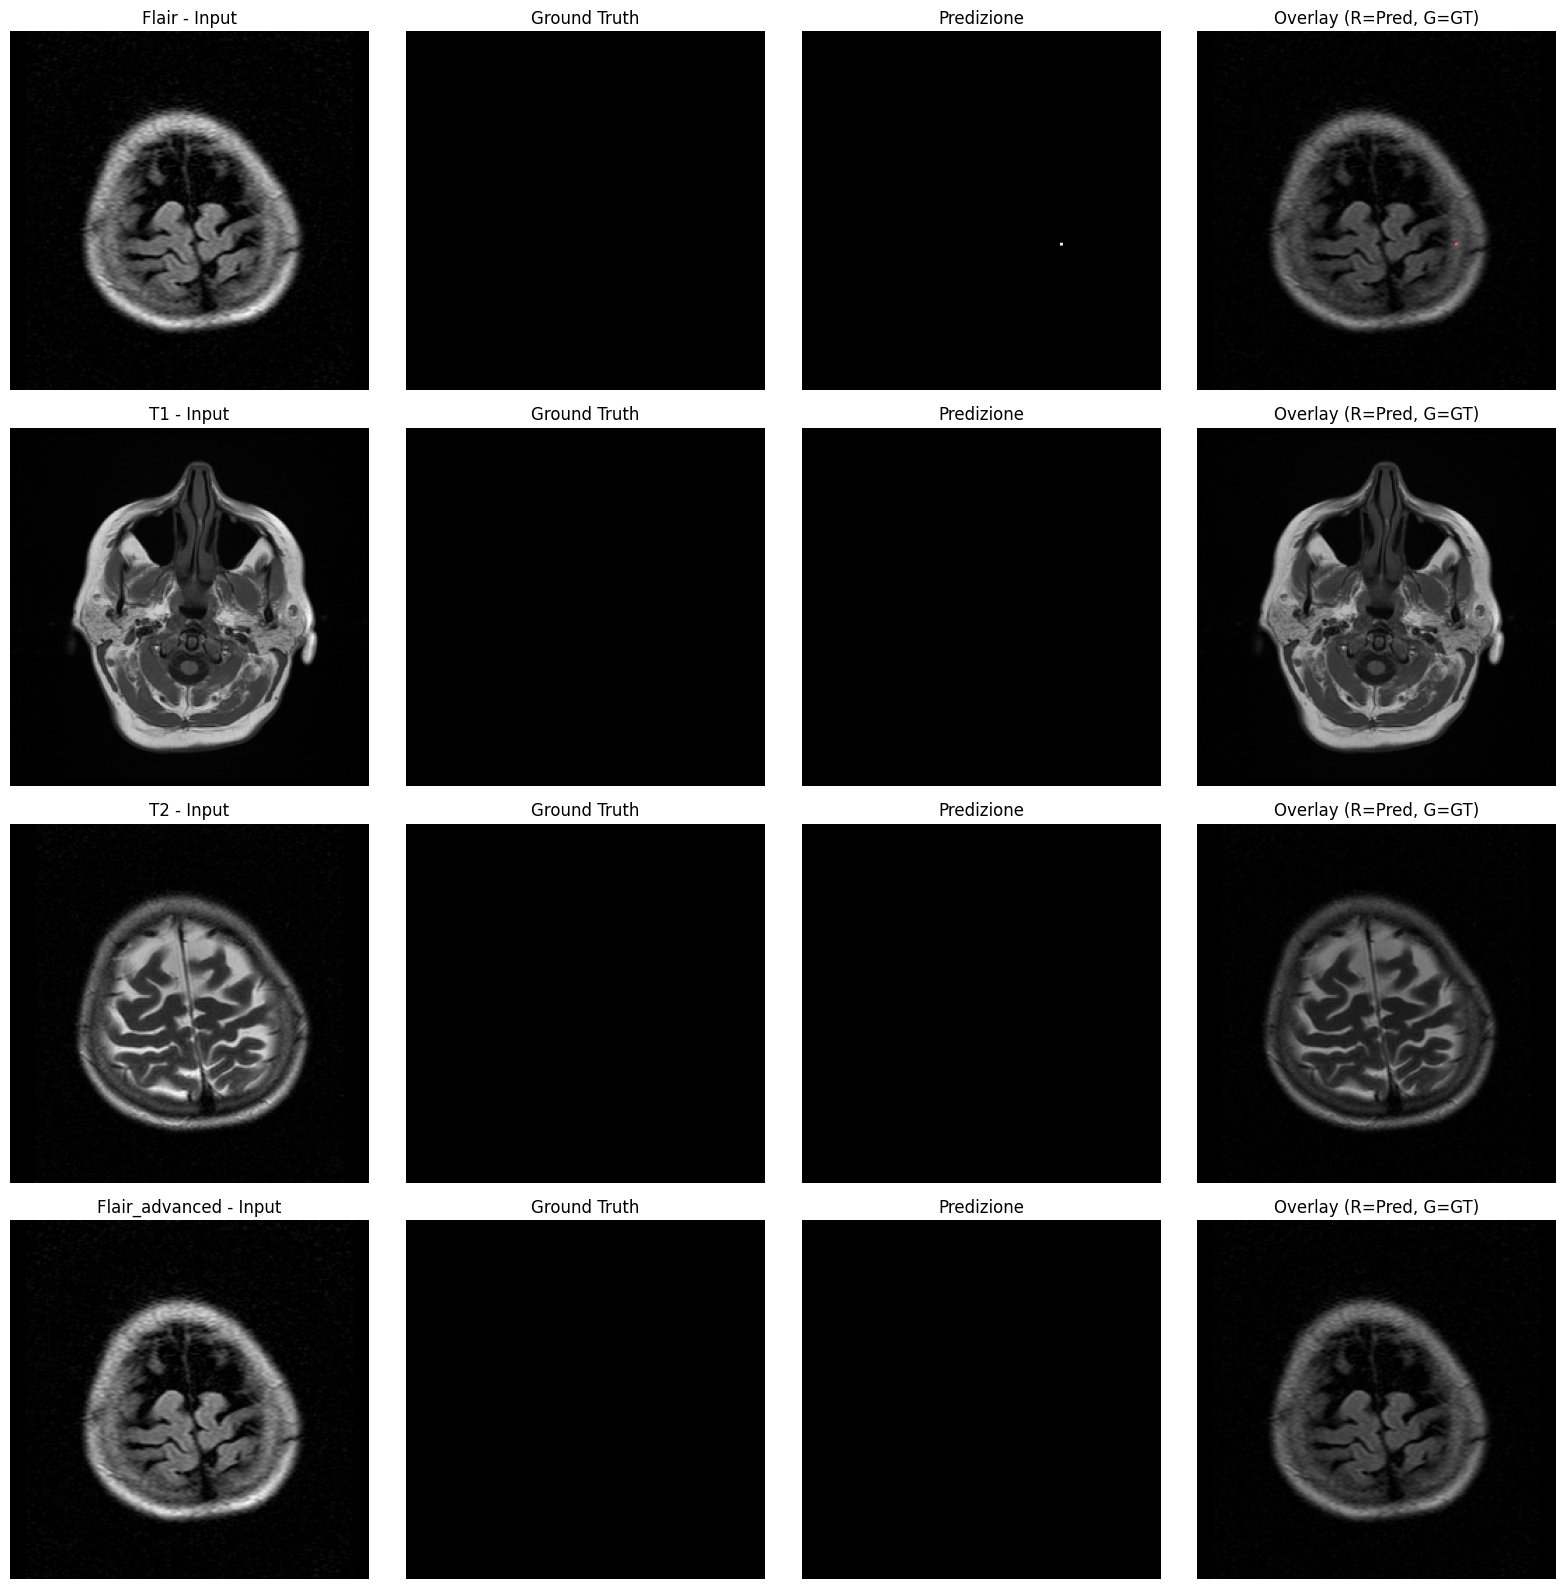

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
# Visualizzazione comparativa finale
fig, axes = plt.subplots(len(modalities_extended), 4, figsize=(16, 4*len(modalities_extended)))

for idx, modality in enumerate(modalities_extended):
    slice_modality = "Flair" if modality == "Flair_advanced" else modality

    slice_path = f'/content/slices/{slice_modality}'
    patients_dict = get_patients_dict(slice_path, modality=slice_modality)
    _, _, test_data = get_train_val_test_data(patients_dict)

    sample_idx = len(test_data[0]) // 2

    img = imageio.imread(test_data[0][sample_idx])
    gt_mask = imageio.imread(test_data[1][sample_idx])

    model = models_dict[modality]
    img_tensor = tf.cast(img, tf.float32) / 255.0
    img_tensor = tf.expand_dims(tf.expand_dims(img_tensor, 0), -1)
    pred = model.predict(img_tensor, verbose=0)[0, :, :, 0]
    pred_binary = (pred > 0.5).astype(np.uint8) * 255

    axes[idx, 0].imshow(img, cmap='gray')
    axes[idx, 0].set_title(f'{modality} - Input')
    axes[idx, 0].axis('off')

    axes[idx, 1].imshow(gt_mask, cmap='gray')
    axes[idx, 1].set_title('Ground Truth')
    axes[idx, 1].axis('off')

    axes[idx, 2].imshow(pred_binary, cmap='gray')
    axes[idx, 2].set_title('Predizione')
    axes[idx, 2].axis('off')

    overlay = np.zeros((*img.shape, 3), dtype=np.uint8)
    overlay[:, :, 0] = img
    overlay[:, :, 1] = img
    overlay[:, :, 2] = img
    overlay[gt_mask > 127, 1] = 255
    overlay[pred_binary > 127, 0] = 255

    axes[idx, 3].imshow(overlay)
    axes[idx, 3].set_title('Overlay (R=Pred, G=GT)')
    axes[idx, 3].axis('off')

plt.tight_layout()
plt.savefig('/content/final_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
files.download('/content/final_comparison.png')

